In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from quantizeRGB import quantizeRGB
from quantizeHSV import quantizeHSV
from computeQuantizationError import computeQuantizationError
# from getHueHists import getHueHists


In [ ]:
# Read the image
img = cv2.imread('baloons.jpg')

# Convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [ ]:
# Show the original image
import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

# Quantize the image with 3 colors
newimg, centres = quantizeRGB(img, 3)

# Show the quantized image
plt.imshow(newimg)
plt.axis('off')
plt.title('Quantized Image')
plt.show()

# Quantize the image with 3 colors
newimg2, centres2 = quantizeHSV(img, 3)

# Show the quantized image
plt.imshow(newimg2)
plt.axis('off')
plt.title('Quantized Image')
plt.show()



In [ ]:
# compute the quantization error
error = computeQuantizationError(img, newimg)
error1 = computeQuantizationError(img, newimg2)
print('Quantization error (RGB):', error)
print('Quantization error (HSV):', error1)

In [ ]:
from sklearn.cluster import KMeans
def getHueHists(im, k):
    # Convert the image to HSV
    hsvimg = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    # Reshape the image to be a list of pixels
    pixels = hsvimg.reshape((-1, 3))
    # find the min and max pixel value in hue channel
    minHue = np.min(pixels[:, 0])
    maxHue = np.max(pixels[:, 0])
    print('Min hue:', minHue)
    print('Max hue:', maxHue)
    # Compute the histogram of the hue channel with equally spaced bins
    histEqual = np.histogram(pixels[:, 0], bins=180, range=(0, 180))[0]
    # plot histogram
    plt.bar(range(180), histEqual)
    plt.title('Equal bins')
    plt.show()
    
    # Fit a k-means estimator to the Hue channel
    estimator = KMeans(n_clusters=k)
    estimator.fit(pixels[:, 0].reshape(-1, 1))
    # Quantize the hue space
    labels = estimator.predict(pixels[:, 0].reshape(-1, 1))
    # Compute the histogram of the hue channel with k bins
    histClustered = np.histogram(labels, bins=k, range=(0, k))[0]
    # plot histogram
    plt.bar(range(k), histClustered)
    plt.title('Clustered bins')
    plt.show()
    return histEqual, histClustered

In [ ]:
# compute the hue histograms
histEqual, histQuantized = getHueHists(img, 3)

# Plot the histograms
# plt.figure()
# plt.bar(np.arange(0, 3), histEqual, 0.35, label='Equalized')
# plt.bar(np.arange(0, 3)+ 0.35, histQuantized, 0.35, label='Quantized')
# plt.xlabel('Hue bin')
# plt.ylabel('Frequency')
# plt.title('Hue histogram')
# plt.legend()
# plt.show()

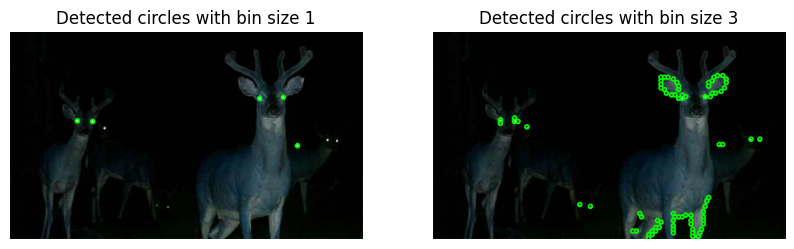

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Use gradient direction to adjust the circle candidates
def calculate_gradient_direction(edge_image):
    gradient_x = cv2.Sobel(edge_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(edge_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_direction = np.arctan2(gradient_y, gradient_x)
    gradient_direction = np.rad2deg(gradient_direction)
    gradient_direction = (gradient_direction + 360) % 360  # Ensure angle is within 0 to 360 degrees
    return gradient_direction

def detectCircles(image, radius, bin_threshold = 0.7, post_process = True, num_thetas= 100, useGradient=False, bin_size = 1):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    gray_image = cv2.GaussianBlur(gray_image, (5, 5), 1)

    # Apply Canny edge detection
    edge_image = cv2.Canny(gray_image, 100, 200)

    #image size
    img_height, img_width = edge_image.shape[:2]
    
    # R and Theta ranges
    dtheta = int(360 / num_thetas)
    
    # Thetas is bins created from 0 to 360 degree with increment of the dtheta
    thetas = np.arange(0, 360, step=dtheta)
    
    # Calculate Cos(theta) and Sin(theta) it will be required later
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    
    # Evaluate and keep ready the candidate circles dx and dy for different delta radius
    # based on the the parametric equation of circle.
    circle_candidates = []
    for t in range(num_thetas):
        circle_candidates.append((int(radius * cos_thetas[t]), int(radius * sin_thetas[t])))
  
    accumulator = defaultdict(int)

    # calculate gradient direction using edge_image
    gradient_direction = calculate_gradient_direction(edge_image)
    for y in range(img_height):
        for x in range(img_width):
            if edge_image[y][x] != 0: #white pixel
                # Found an edge pixel so now find and vote for circle from the candidate circles passing through this pixel.
                if useGradient:
                    # Use gradient direction to adjust the circle candidates
                    for dx, dy in circle_candidates:
                        adjusted_dx = int(dx * np.cos(np.deg2rad(gradient_direction[y][x]))) + int(dy * np.sin(np.deg2rad(gradient_direction[y][x])))
                        adjusted_dy = int(dx * np.sin(np.deg2rad(gradient_direction[y][x]))) - int(dy * np.cos(np.deg2rad(gradient_direction[y][x])))
                        x_center = x - adjusted_dx
                        y_center = y - adjusted_dy
                        quantized_x = int(x_center / bin_size) * bin_size
                        quantized_y = int(y_center / bin_size) * bin_size
                        accumulator[(quantized_x, quantized_y)] += 1  # vote for current candidate
                else:
                    for rcos_t, rsin_t in circle_candidates:
                        x_center = x - rcos_t
                        y_center = y - rsin_t
                        quantized_x = int(x_center / bin_size) * bin_size
                        quantized_y = int(y_center / bin_size) * bin_size
                        accumulator[(quantized_x, quantized_y)] += 1 #vote for current candidate
  
    # Output image with detected lines drawn
    output_img = image.copy()
    # Output list of detected circles. A single circle would be a tuple of (x,y,r,threshold) 
    out_circles = []
  
    # Sort the accumulator based on the votes for the candidate circles 
    for candidate_circle, votes in sorted(accumulator.items(), key=lambda i: -i[1]):
        x, y = candidate_circle
        current_vote_percentage = votes / num_thetas
        if current_vote_percentage >= bin_threshold: 
            # Shortlist the circle for final result
            out_circles.append((x, y))
      
  
    # Post process the results, can add more post processing later.
    if post_process :
        pixel_threshold = 5
        postprocess_circles = []
        for x, y in out_circles:
            # Exclude circles that are too close of each other
            # all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc, v in postprocess_circles)
            # Remove nearby duplicate circles based on pixel_threshold
            if all(abs(x - xc) > pixel_threshold or abs(y - yc) > pixel_threshold for xc, yc in postprocess_circles):
                postprocess_circles.append((x, y))
        out_circles = postprocess_circles  
    
    # Draw shortlisted circles on the output image
    for x, y in out_circles:
        output_img = cv2.circle(output_img, (x,y), radius, (0,255,0), 2)
  
    return output_img, out_circles, accumulator


# Detect circles
radius1 = 3
radius2 = 78
img1 = cv2.imread('eyes_deer.jpg')
img2 = cv2.imread('sports_balls.jpg')
outimg1, circles11, accumulator11 = detectCircles(img1, radius1, bin_size=1)
outimg2, circles12, accumulator12 = detectCircles(img1, radius1, bin_size=3)
# outimg3, circles21, accumulator21 = detectCircles(img2, radius2)
# outimg4, circles22, accumulator22 = detectCircles(img2, radius2, bin_size=2)

# Show the output image in 2 subplots
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(outimg1)
plt.axis('off')
plt.title('Detected circles with bin size 1')
plt.subplot(1, 2, 2)
plt.imshow(outimg2)
plt.axis('off')
plt.title('Detected circles with bin size 3')
plt.show()

# plt.figure(figsize=(10, 10))
# plt.subplot(1, 2, 1)
# plt.imshow(outimg3)
# plt.axis('off')
# plt.title('Detected circles with bin size 1')
# plt.subplot(1, 2, 2)
# plt.imshow(outimg4)
# plt.axis('off')
# plt.title('Detected circles with bin size 5')
# plt.show()


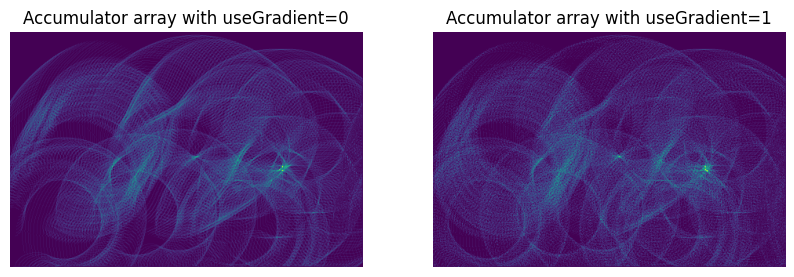

In [60]:
# convert accumulator to image
def accumulator_to_image(accumulator,img):
    img_height, img_width = img.shape[:2]
    acc = np.zeros((img_height, img_width))
    for key, value in accumulator.items():
        x, y = key
        # cap the value to the max value of the image
        x = min(x, img_width - 1)
        y = min(y, img_height - 1)
        acc[y, x] = value
    return acc
# Show the accumulator array
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(accumulator_to_image(accumulator22,img2))
plt.axis('off')
plt.title('Accumulator array with useGradient=0')
plt.subplot(1, 2, 2)
plt.imshow(accumulator_to_image(accumulator21,img2))
plt.axis('off')
plt.title('Accumulator array with useGradient=1')
plt.show()

In [23]:
# make a 2d array of shape (img_height, img_width) with the accumulator values
def accumulator_to_image(accumulator, img_height, img_width):
    acc = np.zeros((img_height, img_width))
    for key, value in accumulator.items():
        x, y = key
        acc[y, x] = value
    return acc

dict_values([1, 43, 14, 33, 46, 28, 71, 50, 40, 32, 7, 24, 13, 6, 1, 1, 16, 30, 28, 66, 22, 1, 23, 33, 13, 64, 21, 22, 15, 1, 1, 38, 18, 23, 10, 10, 1, 2, 7, 86, 90, 45, 4, 1, 3, 71, 1, 3, 11, 1, 16, 33, 34, 64, 24, 42, 11, 19, 27, 12, 2, 4, 12, 1, 4, 1, 1, 1, 4, 4, 23, 1, 20, 2, 7, 1, 47, 15, 33, 17, 74, 60, 20, 48, 39, 7, 24, 13, 6, 2, 6, 23, 31, 28, 34, 22, 1, 22, 33, 13, 62, 21, 22, 15, 1, 1, 27, 13, 42, 11, 10, 1, 2, 46, 88, 62, 45, 4, 1, 3, 60, 1, 4, 29, 2, 47, 15, 39, 13, 25, 59, 21, 32, 1, 3, 2, 2, 14, 1, 26, 32, 4, 26, 7, 55, 8, 52, 4, 4, 3, 4, 4, 83, 2, 13, 78, 38, 51, 28, 4, 8, 3, 3, 4, 45, 60, 29, 2, 2, 3, 2, 10, 32, 9, 23, 27, 34, 30, 48, 14, 4, 8, 3, 4, 4, 1, 11, 27, 52, 8, 12, 3, 10, 114, 15, 82, 45, 4, 61, 1, 4, 16, 4, 2, 38, 30, 30, 1, 1, 26, 1, 26, 26, 9, 23, 13, 9, 7, 26, 3, 25, 1, 1, 27, 29, 39, 13, 33, 22, 1, 15, 8, 16, 10, 13, 1, 4, 34, 58, 18, 32, 4, 1, 1, 28, 8, 42, 18, 81, 24, 32, 4, 9, 22, 4, 25, 14, 49, 1, 4, 1, 4, 1, 3, 29, 1, 1, 1, 1, 7, 19, 4, 23, 37, 65, 

In [63]:
def plotCircles(img1, circles, radius):
    #convert to rgb
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    # Draw the circles of radius 1
    for i in range(len(circles)):
        # draw the outer circle
        cv2.circle(img1, (circles[i][0], circles[i][1]), radius, (0, 255, 0), 2)

    # Show the image
    plt.imshow(img1)
    plt.axis('off')
    # plt.title('Detected circles')
    plt.show()
    

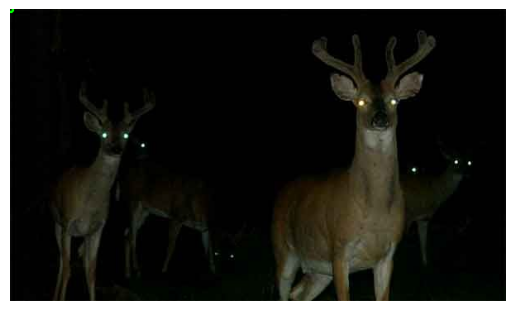

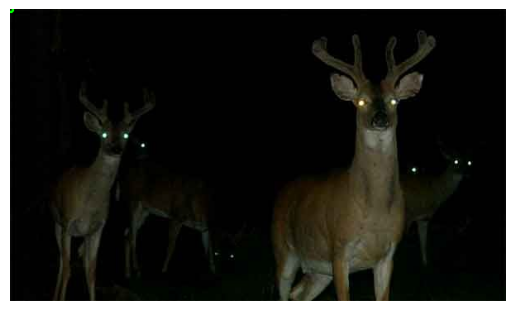

In [64]:
plotCircles(img1, circles11, radius1)
# plotCircles(img1, circles12, radius1)
# plotCircles(img2, circles21, radius2)
# plotCircles(img2, circles22, radius2)

In [ ]:
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")


In [ ]:
def get_depth(img, feature_extractor, model):

    # prepare image for the model
    inputs = feature_extractor(images=img, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=img.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # visualize the prediction
    output = prediction.squeeze().cpu().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [ ]:
img1 = Image.open('img1.jpg')
img2 = Image.open('img2.jpg')

#resize images to 40% of original size
img1 = img1.resize((int(img1.width * 0.4), int(img1.height * 0.4)))
img2 = img2.resize((int(img2.width * 0.4), int(img2.height * 0.4)))

depth1 = get_depth(img1, feature_extractor, model)
depth2 = get_depth(img2, feature_extractor, model)

# get difference between the two depths
diff = np.abs(np.array(depth1) - np.array(depth2))
# normalize between 0 and 255
diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff)) * 255

from matplotlib import pyplot as plt

plt.imshow(diff, cmap='gray')
plt.axis('off')
plt.title('Depth difference')
plt.show()

In [ ]:
# print histogram of the difference
plt.hist(diff.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')